In [23]:

import os 
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("Google_api_key")


## LangGraph Chatbot with Tools

### ⚡ Quick Start - Run these cells in order:

| Step | Cell | Description |
|------|------|-------------|
| 1 | Cell 2 | Initialize the Google LLM |
| 2 | Cell 8 | Define tools (requires TAVILY_API_KEY) |
| 3 | Cell 7 | Build the agent graph |
| 4 | Cell 12 | Test the agent |

**Note:** If you get `NameError`, restart the kernel and run cells in order above.

In [24]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")

# 1. Get the API Key safely
# Ensure your environment variable is named "GOOGLE_API_KEY" (or match the string below exactly)


if not api_key:
    raise ValueError("API Key not found! Please set the GOOGLE_API_KEY environment variable.")

# 2. Initialize the Model
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    google_api_key=api_key,  # FIXED: Parameter name is google_api_key
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# 3. Test the model
try:
    response = llm.invoke("What is the main advantage of using LangChain?")
    print(response.content)
except Exception as e:
    print(f"An error occurred: {e}")

[]


In [25]:
def generate_response(query):
    response = llm.invoke(query)
    return response.content[0]

generate_response("What is the capital of France?")

{'type': 'text',
 'text': 'The capital of France is **Paris**.',
 'extras': {'signature': 'EooBCocBAXLI2nzLu3y2wzYxnHmgrABFTXe/9WWMBbQCv+7TgPQYwuyfCPk5y08ZaOFEEkBpgdEGjAWUkesYb0lF58pbnknoBslutvlrU2rWEiIAYWcfXR9uzKhjQ1mX3wEb69j6fnYaX+Q3cW7ciBS817+3Rdm/Qf0V38mR1H3Lxa9ixqn8Yd+gvNlU'}}

In [26]:
# NOTE: Run Cell 5 (State definitions) BEFORE this cell!
# This is a simple agent without tools - for a tool-enabled agent, skip to Cell 7

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph, END

# 1. Define the node function
def agent_node(state):
    # Get the messages from the state
    messages = state['user_query'] if 'user_query' in state else state['input']
    
    # We can handle both string input or list of messages
    if isinstance(messages, str):
        messages = [("user", messages)]
        
    # Invoke the LLM
    response = llm.invoke(messages)
    
    # Return the update to the state (this will be appended to 'output')
    return {"output": [response]}

# 2. Build the Graph (UserState is defined in Cell 5)
workflow = StateGraph(UserState)
workflow.add_node("agent", agent_node)
workflow.add_edge(START, "agent")

# 3. Compile the graph (This creates the 'runnable' object)
app = workflow.compile()

print("Simple agent (no tools) compiled successfully!")

Simple agent (no tools) compiled successfully!


In [27]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class UserState(TypedDict):
    user_query: str
    topic: str
    # IMPORTANT: Use add_messages so new messages are appended, not overwritten
    output: Annotated[list[BaseMessage], add_messages]

class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

Creatinig the tools for getting the topic of the user query and doing research ,taking sall question test 

In [32]:
# NOTE: Run Cell 2 (LLM init) and Cell 8 (tools definition) BEFORE this cell!

from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import BaseMessage, HumanMessage

# 1. Define State (Standard "messages" key works best with pre-built tools)
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# 2. Define the Agent Node (The Brain)
def assistant(state: AgentState):
    # llm_with_tools is defined in Cell 8
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 3. Build the Graph
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("assistant", assistant)
workflow.add_node("tools", tool_node)  # tool_node is defined in Cell 8

# Add Edges
workflow.add_edge(START, "assistant")

# Conditional Edge: Check if the LLM wants to use a tool
# If yes -> go to "tools"
# If no -> go to END
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)

# Edge back from tools to assistant (so it can read the search results)
workflow.add_edge("tools", "assistant")

# 4. Compile the Application
app = workflow.compile()

print("Agent graph compiled successfully!")

Agent graph compiled successfully!


In [31]:
# =============================================================================
# TOOLS DEFINITION - Run this cell AFTER Cell 2 (LLM init) and BEFORE Cell 7
# =============================================================================

import os
import getpass
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Setup Tavily API Key
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter Tavily API Key: ")

# --- TOOL 1: FIND PROBLEM COLLECTIONS ---
@tool
def find_popular_leetcode_problems(topic: str):
    """
    Uses Tavily to find curated lists of popular LeetCode problems for a specific topic.
    """
    search = TavilySearchResults(max_results=5, search_depth="advanced", include_raw_content=True)
    query = f"Top 50 LeetCode interview questions for {topic} list"
    return search.invoke(query)

# --- TOOL 2: GET EXPLANATIONS ---
@tool
def get_dsa_explanation(concept: str):
    """
    Searches GeeksforGeeks and NeetCode for explanations of a concept.
    """
    search = TavilySearchResults(max_results=3, search_depth="advanced")
    query = f"{concept} explanation site:geeksforgeeks.org OR site:neetcode.io"
    return search.invoke(query)

# --- TOOL 3: GENERAL SEARCH ---
@tool
def tavily_search(query: str):
    """
    General web search tool using Tavily for any query.
    """
    search = TavilySearchResults(max_results=3)
    return search.invoke(query)

# Define tools list, tool_node, and bind to LLM
tools = [find_popular_leetcode_problems, get_dsa_explanation, tavily_search]
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

print("✓ Tools defined and bound to LLM!")
print(f"  Available tools: {[t.name for t in tools]}")


✓ Tools defined and bound to LLM!
  Available tools: ['find_popular_leetcode_problems', 'get_dsa_explanation', 'tavily_search']


Test Agent : which will generate the question and then user will be able to give answer and question will be send to the api


In [29]:
def Examiner_agent(topic: str) -> list[str]:
    """
    Generates 10 MCQ questions based on the topic.
    """
    
    # 1. Create a specific instruction
    prompt = ChatPromptTemplate.from_template(
        """You are an expert examiner.
        Generate exactly 10 distinct Multiple Choice Questions (MCQs) on the topic: {topic}.
        
        Rules:
        1. Return ONLY the questions (no intro text like "Here are the questions").
        2. Separate each question with a "|||" symbol so I can split them later.
        3. Include 4 options and the correct answer for each.
        """
    )
    
    # 2. Create the chain (using the llm defined in Cell 2)
    chain = prompt | llm
    
    # 3. Invoke with the user's topic
    response = chain.invoke({"topic": topic})
    
    # 4. Process the text into a list
    # Fix: Ensure raw_text is a string, as some models return content as a list of parts
    raw_text = response.content
    if isinstance(raw_text, list):
        raw_text = "".join([str(part) for part in raw_text])
        
    question_list = [q.strip() for q in raw_text.split("|||") if q.strip()]
    
    return question_list

In [30]:
# This cell is now deprecated - Tools are defined in Cell 8
# You can skip this cell and run Cell 8 instead

print("⚠️ Skip this cell - Tools are now defined in Cell 8")

⚠️ Skip this cell - Tools are now defined in Cell 8


In [ ]:
# --- TEST 1: Simple Query (No Tools needed) ---
print("--- Test 1: Chat ---")
query1 = "Hi, I am Abhishek. What can you do?"
response1 = app.invoke({"messages": [HumanMessage(content=query1)]})
print(response1["messages"][-1].content)


# --- TEST 2: Complex Query (Requires Tavily Search) ---
print("\n--- Test 2: Research (Tool Usage) ---")
query2 = "What is the current weather in San Francisco?"
response2 = app.invoke({"messages": [HumanMessage(content=query2)]})

# Print the final answer
print("Final Answer:", response2["messages"][-1].content)

# Optional: Inspect the tool usage
print("\n[Debug] Message History:")
for msg in response2["messages"]:
    content_preview = str(msg.content)[:50] if msg.content else ""
    print(f"{msg.type}: {content_preview}...")

--- Test 1: Chat ---
[{'type': 'text', 'text': "Hi Abhishek! It’s great to meet you.\n\nI am a large language model, trained by Google. Think of me as a versatile digital assistant that can process and generate information across a wide range of topics.\n\nHere are some of the things I can help you with:\n\n### 1. **Writing and Content Creation**\n*   **Drafting:** I can help you write emails, essays, cover letters, or blog posts.\n*   **Creative Writing:** I can write stories, poems, scripts, or even song lyrics.\n*   **Editing:** I can check your grammar, rewrite sentences to change the tone, or summarize long documents.\n\n### 2. **Answering Questions & Learning**\n*   **General Knowledge:** I can answer questions about history, science, geography, pop culture, and more.\n*   **Explaining Concepts:** I can take complex topics (like quantum physics or how a mortgage works) and explain them in simple terms.\n*   **Tutorials:** I can provide step-by-step guides on how to do various thi

NameError: name 'response2' is not defined

In [ ]:
# # creating a supervisor agent which will look which agent should be called 
# def supervisor_agent(query:str)->str:
#     '''Give th Agent name According to the user need  '''
#     prompt = c

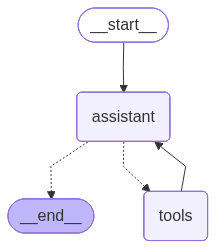

In [33]:
from IPython.display import Image, display

# CORRECT: Use 'app', not 'graph'
display(Image(app.get_graph().draw_mermaid_png()))